In [ ]:
!pip install torch_lr_finder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
import random
from collections import defaultdict
from PIL import Image
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from torch_lr_finder import LRFinder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import copy
import gc

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # para múltiples GPUs

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Semilla aleatoria establecida en {seed}")

def get_train_transform(img_size):
    # Data augmentations
    #Se cambian a valores más moderados
    return  transforms.Compose([
    transforms.Resize((img_size, img_size)),

    #Augmentations de color
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),

    # Augmentations espaciales / de forma
    transforms.RandomHorizontalFlip(p=0.5), # Espejo
    #transforms.RandomRotation(12),
    # Mueve, escala e inclina la mano
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),

    # Normalización y borrado
    transforms.ToTensor(),                   # Convertir a Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

    # Random Erasing debe ir después de ToTensor y Normalize
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

def get_val_transform(img_size):
    #Solo se normalizan y redimensionan las imagenes del test y val
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="Entrenando", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

def graficar_loss(history_loss_train, history_loss_val):
    plt.figure(figsize=(10, 6))
    #mostrar etiquetas para saber que linea es cada una
    plt.plot(history_loss_train)
    plt.plot(history_loss_val)
    plt.title('Loss durante el Entrenamiento')
    plt.ylabel('Loss')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.xlabel('Épocas')

def graficar_accuracy(history_acc_train, history_acc_val):
    plt.figure(figsize=(10, 6))
    plt.plot(history_acc_train)
    plt.plot(history_acc_val)
    plt.title('Accuracy durante el Entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.xlabel('Épocas')

In [ ]:
class SignLanguageDataset(Dataset):
    def __init__(self, file_list, label_map, transform=None):
        self.file_list = file_list
        self.transform = transform
        # El mapa de etiquetas se pasa desde fuera
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        # La etiqueta es la carpeta
        letra = img_path.parent.name
        label = self.label_map[letra]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error cargando imagen {img_path}: {e}")
            return torch.randn(3, 224, 224), -1

        if self.transform:
            img = self.transform(img)
        return img, label

## Modelo con las capas descongeladas que mejor desempeño tuvo para un entrenamiento completo

In [ ]:
print("Descomprimiendo dataset...")
!unzip -q "/content/drive/MyDrive/IA Avanzada/Dataset Lengua de Señas/dataset_final.zip" -d "/content/dataset_local/"

Descomprimiendo dataset...


In [ ]:
TRAIN_DIR = "/content/dataset_local/dataset_final"
# Split 90-5-5
VAL_SPLIT_SIZE = 0.1
TEST_SPLIT_SIZE = 0.1
BATCH_SIZE = 256
SEED = 42
IMG_SIZE = 224

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")
if device.type == "cuda":
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")

print(f"Escaneando {TRAIN_DIR} para crear divisiones...")
train_root = Path(TRAIN_DIR)
all_files = []
all_labels_text = [] # Guardamos A, B, ... , Z

class_names = sorted([d.name for d in train_root.iterdir() if d.is_dir()])
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
NUM_CLASSES = len(class_names)

for class_name in class_names:
    class_dir = train_root / class_name
    files = list(class_dir.glob('*.[jp][pn]g'))
    all_files.extend(files)
    all_labels_text.extend([class_name] * len(files))

print(f"Total de imágenes encontradas: {len(all_files)}")
print(f"Número de clases: {NUM_CLASSES}")

size_val_test = VAL_SPLIT_SIZE + TEST_SPLIT_SIZE

train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files,
    all_labels_text,
    test_size=size_val_test,
    random_state=SEED,
    stratify=all_labels_text
)

#Se hace la division 5% de test-val
relative_test_size = TEST_SPLIT_SIZE / size_val_test

val_files, test_files, _, _ = train_test_split(
    temp_files,
    temp_labels,
    test_size=relative_test_size,
    random_state=SEED,
    stratify=temp_labels
)

print("\n--- ¡División completada! ---")
print(f"Imágenes de Entrenamiento: {len(train_files)} ({len(train_files)/len(all_files):.0%})")
print(f"Imágenes de Validación:   {len(val_files)} ({len(val_files)/len(all_files):.0%})")
print(f"Imágenes de Prueba:       {len(test_files)} ({len(test_files)/len(all_files):.0%})")

Semilla aleatoria establecida en 42

Usando dispositivo: cuda
GPU detectada: NVIDIA L4
Escaneando /content/dataset_local/dataset_final para crear divisiones...
Total de imágenes encontradas: 7007
Número de clases: 26

--- ¡División completada! ---
Imágenes de Entrenamiento: 5605 (80%)
Imágenes de Validación:   701 (10%)
Imágenes de Prueba:       701 (10%)


In [ ]:
set_seed(SEED)

train_tfm = get_train_transform(IMG_SIZE)
val_tfm = get_val_transform(IMG_SIZE)

train_dataset = SignLanguageDataset(train_files, label_map, transform=train_tfm)
val_dataset = SignLanguageDataset(val_files, label_map, transform=val_tfm)
test_dataset = SignLanguageDataset(test_files, label_map, transform=val_tfm)

num_cpus = os.cpu_count()

print(f"Usando {num_cpus} workers para cargar datos...")

# DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_cpus,  # Usa todos los CPUs
                          pin_memory=True,
                          prefetch_factor=2    # Precarga 2 lotes
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=num_cpus,
                        pin_memory=True,
                        prefetch_factor=2
                       )

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_cpus,
                         pin_memory=True,
                         prefetch_factor=2
                        )

print(f"\nDataLoaders listos.")
print(f"Clases: {NUM_CLASSES}")

Semilla aleatoria establecida en 42
Usando 12 workers para cargar datos...

DataLoaders listos.
Clases: 26


In [ ]:
LR = 1e-4
EPOCHS = 100
set_seed(SEED)

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# Congelar todo primero
for param in model.parameters():
    param.requires_grad = False

# Descongelar Bloques 6, 7 y 8
print("Descongelando bloques 6, 7 y 8...")
for block in [6, 7, 8]:
    for param in model.features[block].parameters():
        param.requires_grad = True

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Weight Decay ayuda a regularizar las capas descongeladas
optimizer = optim.AdamW(params_to_update, lr=LR, weight_decay=0.01)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_metric = float('-inf')
best_model_weights = None

print(f"Iniciando entrenamiento de EfficientNet b0...")
patience = 20 # Paciencia total para detener el entrenamiento
patience_counter = 0

for epoch in range(EPOCHS):
    # Entrenar y Validar
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    # Paso del Scheduler (revisa si debe bajar el LR)
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    print(f"Época {epoch+1}/{EPOCHS} [LR: {current_lr:.2e}] -> "
          f"Train: {train_acc:.2f}% | Val: {val_acc:.2f}% (Loss: {val_loss:.4f})")

    # Guardar historial
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_metric:
        best_val_metric = val_acc
        best_model_weights = copy.deepcopy(model.state_dict())
        patience_counter = 0 # Reiniciar paciencia
        print(f"  -> Mejora en  Val Acc: {val_acc:.2f}%. Guardando pesos.")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  -> Early Stopping: No mejora en {patience} épocas.")
            break

print("\nEntrenamiento finalizado.")

print(f"Cargando el mejor modelo (Val Acc: {best_val_metric:.2f}%) para Test...")
model.load_state_dict(best_model_weights)

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Probando en Test Set"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas finales
final_loss_ef2 = test_loss / len(test_loader)
final_acc_ef2 = accuracy_score(all_labels, all_preds) * 100
final_f1_ef2 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Resultados Finales (EfficientNetb0) ---")
print(f"  -> Test Loss:      {final_loss_ef2:.4f}")
print(f"  -> Test Accuracy:  {final_acc_ef2:.2f}%")
print(f"  -> Test F1-Score:  {final_f1_ef2:.4f}")
print("---------------------------------------")

torch.save(model.state_dict(), 'efficientNet_final_pro_2.pth')


Semilla aleatoria establecida en 42
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 168MB/s]


Descongelando bloques 6, 7 y 8...
Iniciando entrenamiento de EfficientNet b0...


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 1/100 [LR: 1.00e-04] -> Train: 7.56% | Val: 11.27% (Loss: 3.1777)
  -> Mejora en  Val Acc: 11.27%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 2/100 [LR: 1.00e-04] -> Train: 16.90% | Val: 34.66% (Loss: 2.7955)
  -> Mejora en  Val Acc: 34.66%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 3/100 [LR: 1.00e-04] -> Train: 26.33% | Val: 44.37% (Loss: 2.3567)
  -> Mejora en  Val Acc: 44.37%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 4/100 [LR: 1.00e-04] -> Train: 35.66% | Val: 51.78% (Loss: 2.0528)
  -> Mejora en  Val Acc: 51.78%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 5/100 [LR: 1.00e-04] -> Train: 41.36% | Val: 58.92% (Loss: 1.8704)
  -> Mejora en  Val Acc: 58.92%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 6/100 [LR: 1.00e-04] -> Train: 47.48% | Val: 64.76% (Loss: 1.7249)
  -> Mejora en  Val Acc: 64.76%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 7/100 [LR: 1.00e-04] -> Train: 51.22% | Val: 67.05% (Loss: 1.6350)
  -> Mejora en  Val Acc: 67.05%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 8/100 [LR: 1.00e-04] -> Train: 54.75% | Val: 70.90% (Loss: 1.5334)
  -> Mejora en  Val Acc: 70.90%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 9/100 [LR: 1.00e-04] -> Train: 58.48% | Val: 70.61% (Loss: 1.4759)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 10/100 [LR: 1.00e-04] -> Train: 59.11% | Val: 72.47% (Loss: 1.4327)
  -> Mejora en  Val Acc: 72.47%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 11/100 [LR: 1.00e-04] -> Train: 60.71% | Val: 73.32% (Loss: 1.3858)
  -> Mejora en  Val Acc: 73.32%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 12/100 [LR: 1.00e-04] -> Train: 63.21% | Val: 75.32% (Loss: 1.3432)
  -> Mejora en  Val Acc: 75.32%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 13/100 [LR: 1.00e-04] -> Train: 63.44% | Val: 76.46% (Loss: 1.3135)
  -> Mejora en  Val Acc: 76.46%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 14/100 [LR: 1.00e-04] -> Train: 64.37% | Val: 78.74% (Loss: 1.2918)
  -> Mejora en  Val Acc: 78.74%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 15/100 [LR: 1.00e-04] -> Train: 65.67% | Val: 78.32% (Loss: 1.2676)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 16/100 [LR: 1.00e-04] -> Train: 65.69% | Val: 80.03% (Loss: 1.2387)
  -> Mejora en  Val Acc: 80.03%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 17/100 [LR: 1.00e-04] -> Train: 67.96% | Val: 80.60% (Loss: 1.2238)
  -> Mejora en  Val Acc: 80.60%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 18/100 [LR: 1.00e-04] -> Train: 68.58% | Val: 81.60% (Loss: 1.2067)
  -> Mejora en  Val Acc: 81.60%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 19/100 [LR: 1.00e-04] -> Train: 67.92% | Val: 82.45% (Loss: 1.1857)
  -> Mejora en  Val Acc: 82.45%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 20/100 [LR: 1.00e-04] -> Train: 69.12% | Val: 82.31% (Loss: 1.1703)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 21/100 [LR: 1.00e-04] -> Train: 70.72% | Val: 82.03% (Loss: 1.1689)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 22/100 [LR: 1.00e-04] -> Train: 70.63% | Val: 83.45% (Loss: 1.1437)
  -> Mejora en  Val Acc: 83.45%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 23/100 [LR: 1.00e-04] -> Train: 70.17% | Val: 83.02% (Loss: 1.1376)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 24/100 [LR: 1.00e-04] -> Train: 71.88% | Val: 84.59% (Loss: 1.1307)
  -> Mejora en  Val Acc: 84.59%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 25/100 [LR: 1.00e-04] -> Train: 71.79% | Val: 84.17% (Loss: 1.1256)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 26/100 [LR: 1.00e-04] -> Train: 71.40% | Val: 85.16% (Loss: 1.1123)
  -> Mejora en  Val Acc: 85.16%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 27/100 [LR: 1.00e-04] -> Train: 72.58% | Val: 85.16% (Loss: 1.1044)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 28/100 [LR: 1.00e-04] -> Train: 73.93% | Val: 85.45% (Loss: 1.0910)
  -> Mejora en  Val Acc: 85.45%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 29/100 [LR: 1.00e-04] -> Train: 74.24% | Val: 86.88% (Loss: 1.0746)
  -> Mejora en  Val Acc: 86.88%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 30/100 [LR: 1.00e-04] -> Train: 74.27% | Val: 86.45% (Loss: 1.0734)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 31/100 [LR: 1.00e-04] -> Train: 73.95% | Val: 86.73% (Loss: 1.0659)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 32/100 [LR: 1.00e-04] -> Train: 75.04% | Val: 86.02% (Loss: 1.0638)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 33/100 [LR: 1.00e-04] -> Train: 75.54% | Val: 87.45% (Loss: 1.0500)
  -> Mejora en  Val Acc: 87.45%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 34/100 [LR: 1.00e-04] -> Train: 76.41% | Val: 86.45% (Loss: 1.0583)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 35/100 [LR: 1.00e-04] -> Train: 76.32% | Val: 86.73% (Loss: 1.0497)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 36/100 [LR: 1.00e-04] -> Train: 75.65% | Val: 86.45% (Loss: 1.0459)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 37/100 [LR: 1.00e-04] -> Train: 77.59% | Val: 86.88% (Loss: 1.0394)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 38/100 [LR: 1.00e-04] -> Train: 75.91% | Val: 87.30% (Loss: 1.0363)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 39/100 [LR: 1.00e-04] -> Train: 76.63% | Val: 87.59% (Loss: 1.0304)
  -> Mejora en  Val Acc: 87.59%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 40/100 [LR: 1.00e-04] -> Train: 78.20% | Val: 87.02% (Loss: 1.0240)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 41/100 [LR: 1.00e-04] -> Train: 77.00% | Val: 88.02% (Loss: 1.0150)
  -> Mejora en  Val Acc: 88.02%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 42/100 [LR: 1.00e-04] -> Train: 79.11% | Val: 87.45% (Loss: 1.0159)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 43/100 [LR: 1.00e-04] -> Train: 78.29% | Val: 87.59% (Loss: 1.0049)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 44/100 [LR: 1.00e-04] -> Train: 78.55% | Val: 88.16% (Loss: 1.0073)
  -> Mejora en  Val Acc: 88.16%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 45/100 [LR: 1.00e-04] -> Train: 78.36% | Val: 88.30% (Loss: 0.9959)
  -> Mejora en  Val Acc: 88.30%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 46/100 [LR: 1.00e-04] -> Train: 79.45% | Val: 88.30% (Loss: 1.0040)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 47/100 [LR: 1.00e-04] -> Train: 80.36% | Val: 89.02% (Loss: 1.0028)
  -> Mejora en  Val Acc: 89.02%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 48/100 [LR: 1.00e-04] -> Train: 79.96% | Val: 88.59% (Loss: 0.9877)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 49/100 [LR: 1.00e-04] -> Train: 80.32% | Val: 88.73% (Loss: 0.9805)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 50/100 [LR: 1.00e-04] -> Train: 80.11% | Val: 88.30% (Loss: 0.9824)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 51/100 [LR: 1.00e-04] -> Train: 79.55% | Val: 89.59% (Loss: 0.9757)
  -> Mejora en  Val Acc: 89.59%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 52/100 [LR: 1.00e-04] -> Train: 79.96% | Val: 88.59% (Loss: 0.9790)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 53/100 [LR: 1.00e-04] -> Train: 79.45% | Val: 89.44% (Loss: 0.9722)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 54/100 [LR: 1.00e-04] -> Train: 79.30% | Val: 89.59% (Loss: 0.9755)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 55/100 [LR: 1.00e-04] -> Train: 81.25% | Val: 89.44% (Loss: 0.9756)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 56/100 [LR: 1.00e-04] -> Train: 80.18% | Val: 89.02% (Loss: 0.9810)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 57/100 [LR: 1.00e-04] -> Train: 81.37% | Val: 88.59% (Loss: 0.9773)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 58/100 [LR: 1.00e-04] -> Train: 80.93% | Val: 89.73% (Loss: 0.9627)
  -> Mejora en  Val Acc: 89.73%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 59/100 [LR: 1.00e-04] -> Train: 81.18% | Val: 89.87% (Loss: 0.9680)
  -> Mejora en  Val Acc: 89.87%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 60/100 [LR: 1.00e-04] -> Train: 82.05% | Val: 90.01% (Loss: 0.9581)
  -> Mejora en  Val Acc: 90.01%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 61/100 [LR: 1.00e-04] -> Train: 82.25% | Val: 89.44% (Loss: 0.9594)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 62/100 [LR: 1.00e-04] -> Train: 82.32% | Val: 89.73% (Loss: 0.9510)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 63/100 [LR: 1.00e-04] -> Train: 82.34% | Val: 90.16% (Loss: 0.9579)
  -> Mejora en  Val Acc: 90.16%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 64/100 [LR: 1.00e-04] -> Train: 82.18% | Val: 90.01% (Loss: 0.9516)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 65/100 [LR: 1.00e-04] -> Train: 81.59% | Val: 90.01% (Loss: 0.9477)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 66/100 [LR: 1.00e-04] -> Train: 82.64% | Val: 90.16% (Loss: 0.9463)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 67/100 [LR: 1.00e-04] -> Train: 82.69% | Val: 90.44% (Loss: 0.9468)
  -> Mejora en  Val Acc: 90.44%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 68/100 [LR: 1.00e-04] -> Train: 82.60% | Val: 90.01% (Loss: 0.9501)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 69/100 [LR: 1.00e-04] -> Train: 82.53% | Val: 90.73% (Loss: 0.9465)
  -> Mejora en  Val Acc: 90.73%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 70/100 [LR: 1.00e-04] -> Train: 83.51% | Val: 89.87% (Loss: 0.9514)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 71/100 [LR: 1.00e-04] -> Train: 83.43% | Val: 90.01% (Loss: 0.9542)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 72/100 [LR: 1.00e-04] -> Train: 84.23% | Val: 90.30% (Loss: 0.9430)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 73/100 [LR: 1.00e-04] -> Train: 83.43% | Val: 90.30% (Loss: 0.9412)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 74/100 [LR: 1.00e-04] -> Train: 84.34% | Val: 90.16% (Loss: 0.9435)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 75/100 [LR: 1.00e-04] -> Train: 83.16% | Val: 90.01% (Loss: 0.9370)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 76/100 [LR: 1.00e-04] -> Train: 83.48% | Val: 90.01% (Loss: 0.9384)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 77/100 [LR: 1.00e-04] -> Train: 83.62% | Val: 90.58% (Loss: 0.9299)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 78/100 [LR: 1.00e-04] -> Train: 84.62% | Val: 91.16% (Loss: 0.9224)
  -> Mejora en  Val Acc: 91.16%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 79/100 [LR: 1.00e-04] -> Train: 83.91% | Val: 90.73% (Loss: 0.9320)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 80/100 [LR: 1.00e-04] -> Train: 84.48% | Val: 90.44% (Loss: 0.9186)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 81/100 [LR: 1.00e-04] -> Train: 84.26% | Val: 90.30% (Loss: 0.9285)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 82/100 [LR: 1.00e-04] -> Train: 84.07% | Val: 91.30% (Loss: 0.9288)
  -> Mejora en  Val Acc: 91.30%. Guardando pesos.


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 83/100 [LR: 1.00e-04] -> Train: 84.57% | Val: 90.44% (Loss: 0.9306)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 84/100 [LR: 1.00e-04] -> Train: 84.82% | Val: 90.87% (Loss: 0.9217)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 85/100 [LR: 1.00e-04] -> Train: 85.32% | Val: 90.58% (Loss: 0.9247)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 86/100 [LR: 1.00e-04] -> Train: 85.33% | Val: 90.58% (Loss: 0.9279)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 87/100 [LR: 1.00e-05] -> Train: 86.01% | Val: 90.44% (Loss: 0.9198)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 88/100 [LR: 1.00e-05] -> Train: 84.60% | Val: 90.58% (Loss: 0.9206)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 89/100 [LR: 1.00e-05] -> Train: 86.16% | Val: 90.58% (Loss: 0.9176)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 90/100 [LR: 1.00e-05] -> Train: 85.76% | Val: 90.58% (Loss: 0.9182)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 91/100 [LR: 1.00e-05] -> Train: 85.57% | Val: 90.58% (Loss: 0.9169)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 92/100 [LR: 1.00e-05] -> Train: 85.99% | Val: 90.73% (Loss: 0.9168)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 93/100 [LR: 1.00e-05] -> Train: 85.55% | Val: 90.58% (Loss: 0.9192)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 94/100 [LR: 1.00e-05] -> Train: 86.21% | Val: 90.58% (Loss: 0.9213)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 95/100 [LR: 1.00e-05] -> Train: 85.91% | Val: 90.73% (Loss: 0.9171)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 96/100 [LR: 1.00e-05] -> Train: 86.16% | Val: 90.73% (Loss: 0.9175)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 97/100 [LR: 1.00e-05] -> Train: 85.55% | Val: 90.58% (Loss: 0.9171)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 98/100 [LR: 1.00e-06] -> Train: 85.32% | Val: 90.87% (Loss: 0.9144)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 99/100 [LR: 1.00e-06] -> Train: 85.44% | Val: 90.87% (Loss: 0.9164)


Entrenando:   0%|          | 0/22 [00:00<?, ?it/s]

Validando:   0%|          | 0/3 [00:00<?, ?it/s]

Época 100/100 [LR: 1.00e-06] -> Train: 85.67% | Val: 90.58% (Loss: 0.9161)

Entrenamiento finalizado.
Cargando el mejor modelo (Val Acc: 91.30%) para Test...


Probando en Test Set:   0%|          | 0/3 [00:00<?, ?it/s]


--- Resultados Finales (EfficientNetb0) ---
  -> Test Loss:      0.9963
  -> Test Accuracy:  87.02%
  -> Test F1-Score:  0.8698
---------------------------------------


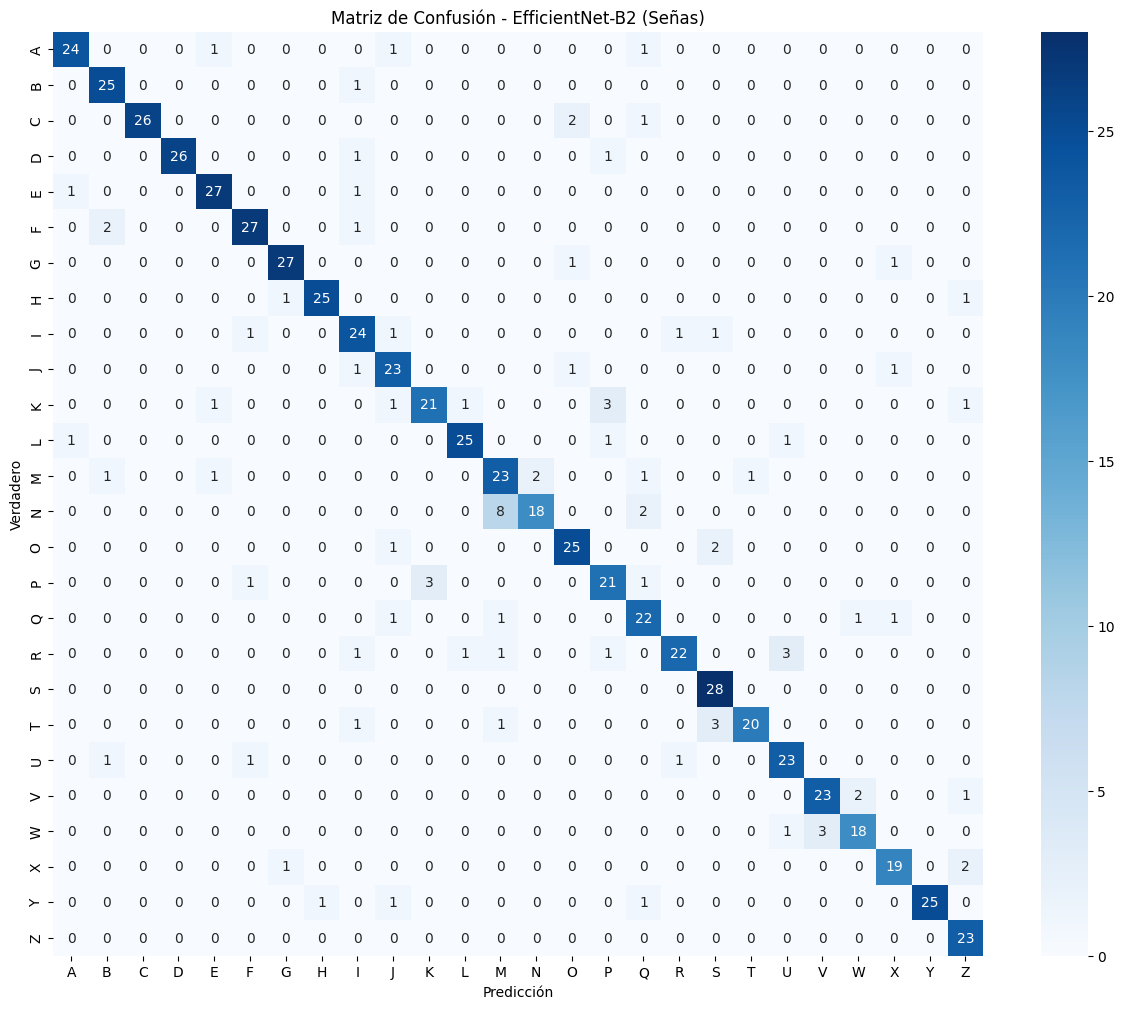

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.label_map.keys(),  # Usar los nombres de clases
            yticklabels=train_dataset.label_map.keys()) # Usar los nombres de clases
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - EfficientNet-B2 (Señas)')
plt.show()

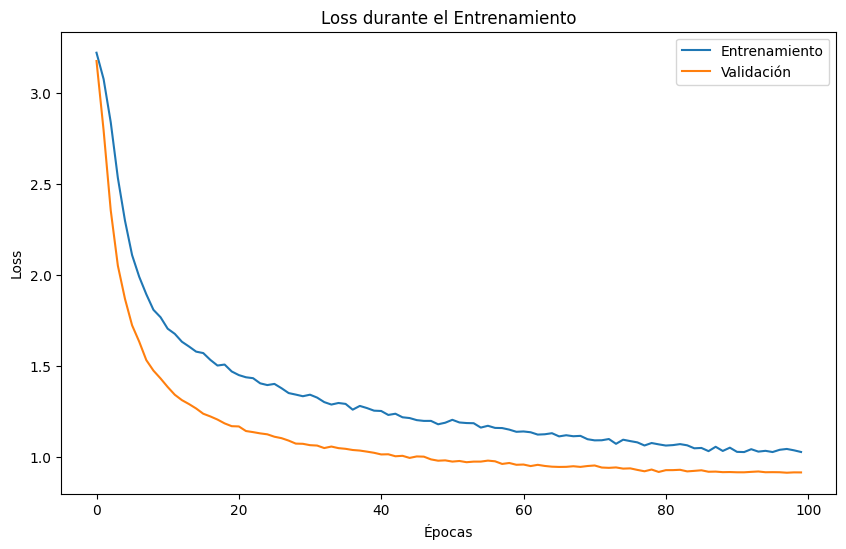

In [ ]:
graficar_loss(history['train_loss'], history['val_loss'])

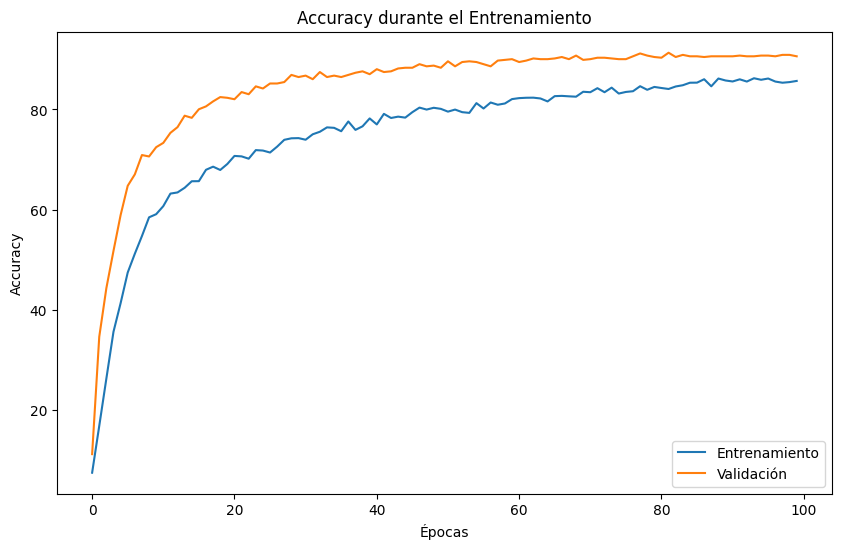

In [ ]:
graficar_accuracy(history['train_acc'], history['val_acc'])

In [ ]:
#Borrar memoria
del model
del train_dataset
del val_dataset
del test_dataset
del train_loader
del val_loader
del test_loader
gc.collect()
torch.cuda.empty_cache()